# Topic Map

In [442]:
import os
import pandas as pd
import re
import nltk
import openai
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt')


pd.set_option('display.max_colwidth', None)
openai.api_key=os.environ['openai_api_key'] 
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
os.makedirs(processed_dir + 'topic-map', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

In [443]:
docs = []
filename = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime('%Y-%m-%d %H:%M:%S')
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)
    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)                 
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))

docs_dict = zip(timestamps, docs)
    
with open(processed_dir + '/topic-map/all-docs-text.txt', 'w') as file: 
	file.writelines("% s % s\n" % (key, value) for key, value in docs_dict) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

1) Pre-calculate Embeddings

In [20]:
from bertopic.backend import OpenAIBackend
# import spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 
#                                             'attribute_ruler', 'lemmatizer'])
# embedding_model = OpenAIBackend('text-embedding-ada-002"')

# import gensim.downloader as api
# ft = api.load('fasttext-wiki-news-subwords-300')
# embedding_model = ft

# all-mpnet-base-v2 - best but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Stochastic Behaviour

In [4]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Limit Number of Topics

In [27]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Improving Default Representation

In [180]:
# max_df 0.7, 1.0 no english stop wrods
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
#  stop_words="english" - seems to interfere with generating topics like 'abortion' and max_df=2, min_df=2, no idea what to tweak these to. 
vectorizer_model = CountVectorizer(stop_words="english")
# vectorizer_model.fit_transform(docs)
# vectorizer_model.get_feature_names_out()

In [432]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    # 'immigration',
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # thsi to seperate out from migration
    'authoritarian',
    
    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    # 'government'    
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# representation_model = zero_shot_model


representation_model = {
    'KeyBERT': keybert_model,
    # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
    'MMR': mmr_model,
    # 'POS': pos_model,
    'ZeroShot': zero_shot_model,
}

## Seed Topics

In [401]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],

    ['minimum wage'],
    ['Nazis'],
    ['pensions'],
    ['crime'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['we are ready'], # The FDI's Campaign slogan     
    ['russia']       
    ]

In [440]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 -  Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  # Hyperparameters
  nr_topics=32, # 'auto', # < less topics
  verbose=True,
  n_gram_range=(1,3) # allows Brothers of Italy
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2023-10-16 20:31:01,313 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-16 20:31:09,097 - BERTopic - Reduced dimensionality
2023-10-16 20:31:09,145 - BERTopic - Clustered reduced embeddings
2023-10-16 20:35:56,520 - BERTopic - Reduced number of topics from 51 to 32


,Topic,Count,Name,Representation,KeyBERT,MMR,ZeroShot,Representative_Docs
0,-1,891,-1_government_this_have_we,"[government, this, have, we, on, not, because, it, be, are]","[government, italy, the government, italian, to the, work, that we, are, what, of the]","[government, this, have, we, on, not, because, it, be, are]","[government, this, have, we, on, not, because, it, be, are]","[We have started important work to make the places that our students frequent more modern and then again on young people, from the culture card to the Merit Card, in favor respectively of the kids with the lowest ISEE and the deserving ones up to the increase of the sports in the suburbs, passing through the five hundred million allocated to scholarships for university housing allocations, we have reiterated the principle that equality and merit are one prerequisite for the other from the provision to simplify the first thirty administrative procedures up to the highly anticipated reform of the procurement code we have started a profound revision to make the State more streamlined, more understandable, more efficient., Let's say that we made a couple of jokes and I told her on the question of Emilia Romagna that I had responded with a long letter to the continuous complaints of President Bonaccini which in my opinion are poorly founded and that on the question of De Angelis I don't think I have to deal with the communication manager of the Region because I think it is the responsibility of the President of the Region, he considers the sixty days a commitment on the part of the government to close the issue of the instruments that I have formalized with the President of the CNEL and they guarantee me that they are able to do this work in sixty days., And obviously it also happened that the bubble inflated so much that at a certain point those who had these credits, mainly companies, could no longer compensate them because they had exhausted, let's say, their possibility of compensating that credit with taxes and could no longer not even to sell them, because even the fiscal drawers of the banks of the other actors who could buy those credits have closed and there are perfectly honest people who have done some work, who have trusted the State, who have done what the State said which found itself in the hands of some work done and money that it cannot take because this has produced this very interesting free measure that today we have thousands of companies that risk collapse and therefore since we inherited it, we now have to look for a solution to prevent thousands of companies from risking collapse because someone could say during the election campaign that they renovated houses for free and that's exactly what we tried to do.]"
1,0,216,0_italy_brothers of italy_brothers_of italy,"[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, government, italy is]","[of italy, italy in, of italy has, italy, the italian, italy is, italy and, italian, in italy, italy has]","[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, government, italy is]","[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, government, italy is]","[precisely on the employment front there is some good news, the latest Bank of Italy report, Ministry of Labor Anpal tells us that between January and February two thousand and twenty-three, that is, January and February of this year, despite the difficult moment that Europe and obviously Italy face, there are Over one hundred thousand new jobs have been created in Italy, an increase more than double that of the first two months of the previous year and about a third greater than the same months of 2019, i.e., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few yea

### Rename and format topics

In [415]:
heatmap_fig = topic_model.visualize_heatmap() # n_clusters=20, topics=[4, 18, 26, 21,44]custom_labels=True
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

In [435]:

# merge topics
# migrants
# topic_model.merge_topics(docs, topics_to_merge=[4, 9])

topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=15, separator=', ')
topic_model.set_topic_labels(topic_labels)
def formatted_label(labels):
    names = [item[0] for item in labels if item[0]]
    top_three = ', '.join(names[:3]).replace('green pass', 'COVID Mandates')

    return top_three

updated_labels = [formatted_label(label) for label in topic_model.get_topics(full=True)['ZeroShot'].values()]

topic_model.set_topic_labels(updated_labels)

# green pass > COVID Mandates
# topic_model.set_topic_labels({1: "COVID Mandates"}) green pass > COVID Mandates 

# topic_model.set_topic_labels({1: "Abortion"})
# topic_model.set_topic_labels({2: "Immigration"})
# topic_model.set_topic_labels({3: "Fake News"})
# topic_model.set_topic_labels({4: "Freedom"})
# topic_model.set_topic_labels({14: "Taxes"})
# topic_model.set_topic_labels({14: "Cost of Living/Inflation"})
# topic_model.set_topic_labels({14: "Election Campaign"})
# topic_model.set_topic_labels({14: "Rape"})
# topic_model.set_topic_labels({14: "Climate Change"})
# topic_model.get_topic_info().head(20)

# Select interesting topics for visualisation


# # outliers why_why why
# topic_model.merge_topics(docs, topics_to_merge=[-1, 46])
# topic_model.merge_topics(docs, topics_to_merge=[29, 22])


interesting_topics=[0, 2, 3, 4, 5, 8, 9, 14, 18, 20, 27]
# If you want to change the topics to something else, whether that is merging them or removing outliers, 
# you can pass a custom list of topics to update them: topic_model.update_topics(docs, topics=my_updated_topics)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# topic_model.get_topic_info()
# representative_docs = topic_model.get_representative_docs(5)
# representative_docs
# topic_model.get_topic_info().head(50)
topic_model.get_topic_info()


,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,ZeroShot,Representative_Docs
0,-1,753,-1_government_this_on_not,"government, this, on","[government, this, on, not, of the, our, you, because, want, with]","[italy, italian, government, the government, that we, for the, we want, to the, are, be]","[government, this, on, not, of the, our, you, because, want, with]","[government, this, on, not, of the, our, you, because, want, with]","[We are arriving with the Ministry of Made in Italy companies to bring to the Council of Ministers, in the next few weeks, a link to the financial maneuver which has as its objective the theme of valorisation of the brand, that is, in fact, a sort of framework law, , to enhance our excellence by focusing on three pillars the relentless fight against counterfeiting and unfair competition, therefore with protection of patents and trademarks, financial instruments to grow small and medium-sized businesses, particularly in the sectors of excellence and training and skills., After that, in my opinion, the next step is to provide answers, no, to continue to work on the answers for which I already say a few days ago I had, speaking with Minister Piante Dosi, with the Undersecretary of Mantua, discussed the possibility of bringing together the Council of Ministers the next opportunity to give a sign of further attention certainly, but also of concreteness with respect to the steps that still need to be taken, here too I have heard Meloni is silent on this matter., And thanks to the crowd that pressured the border guards of the German Democratic Republic to open the gates towards the west and a few minutes later danced joyfully on the ruins of that wall that we were able to embrace tens of millions of our brothers again in the common European ideal precisely to remember the events of one thousand nine hundred and eighty-nine with law sixty-one of the fifteenth of April two thousand and five the Italian Republic declared November 9th, Freedom Day as the anniversary of the demolition of the Berlin Wall, a symbolic event for the liberation of oppressed nations and a hope for democracy for the populations still oppressed by totalitarianism.]"
1,0,256,0_italy_brothers of italy_brothers_of italy,"italy, brothers of italy, brothers","[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, italy is, government]","[italian government, the italian government, of italy, italy in, the italian, italy, italy is not, italy is, the italians, italian]","[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, italy is, government]","[italy, brothers of italy, brothers, of italy, brothers of, italian, italians, in italy, italy is, government]","[This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on 

In [417]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
# intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)

intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [00:16,  9.92it/s]


### See all documents in a topic

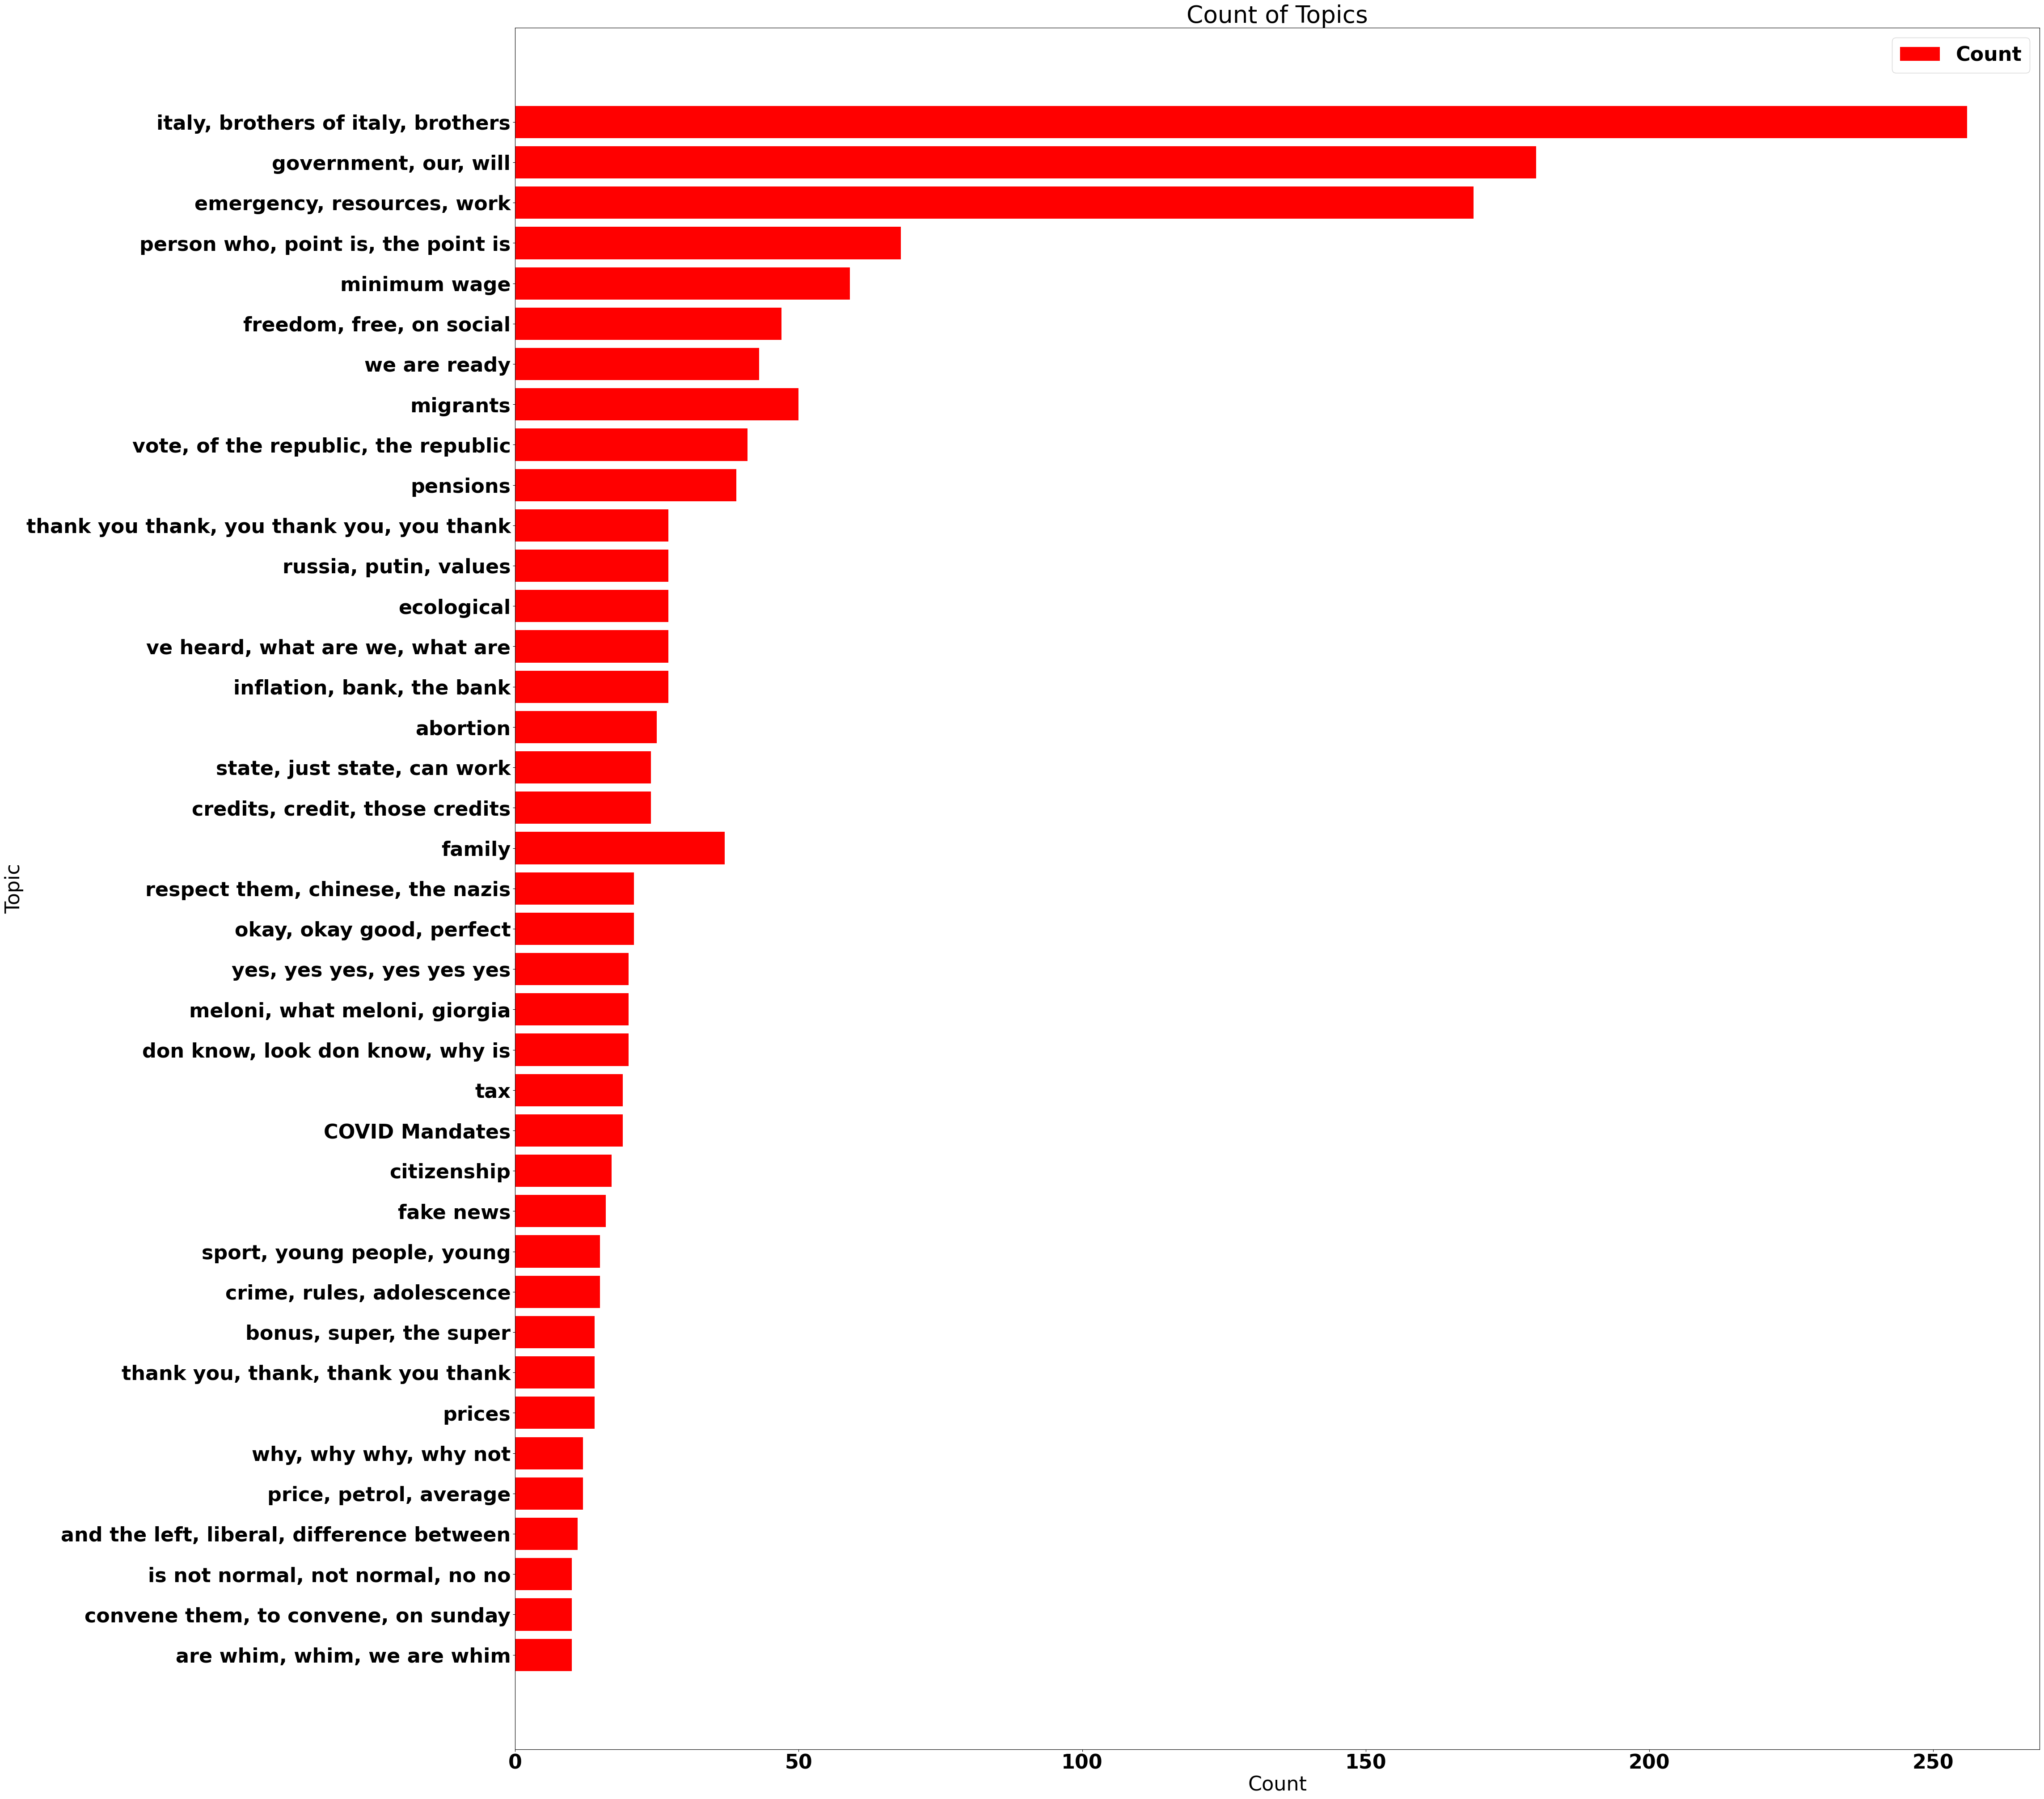

In [436]:
plt_df = topic_model.get_topic_info()
plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)

plt.title('Count of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')

plt.legend()
plt.savefig(processed_dir + 'images/topic-document-counts.png')
plt.show()

In [419]:
# docs_df = topic_model.get_topic_info()
# docs_df[docs_df['Topic'] == 0].head(50)
representative_docs = topic_model.get_representative_docs(5)
representative_docs

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == 0].head(50)


,Topic,document
9,0,"Political debates, a way to create community."
22,0,"We have established the principle that those who cannot work must have assistance, but those who can work must have work from the increase in the number of families who could access discounts on bills to the resources to combat the expensive shopping cart, through the experimentation of food income."
24,0,"From the extension of the Solidarity Fund for mortgages and the guarantee fund for the purchase of the first home for young couples, through to the rule that allows everyone to transform the variable rate mortgage into a fixed rate mortgage, we have given a hand in defending the right to housing from the fiscal truce to the extension of the flat tax for self-employed and VAT numbers, up to the cut in taxation on productivity bonuses and on the highest declared incomes, through the tax relief on tips and the extension of the suspension on Plastic and Sugar Tax, we have begun to build a state that is friendlier to those who produce, from raising the ceiling to the use of cash to the norm to combat open-and-close companies."
26,0,To have the scholarship recognized.
27,0,"We wanted to strengthen the State's attention towards the sick and the world of disabilities from the Pact for the elderly which lays the foundations for an overall reform of policies in favor of the elderly, up to the increase in minimum pensions."
29,0,We have launched the first measures to guarantee a more equitable and just State.
30,0,"And then from the extension of benefits for companies in the South, the valorisation of quality production, up to the presentation of the project to transform post offices into one-stop shops for the public administration to guarantee everyone's right to have easy and fast services."
31,0,"We wanted to establish the principle that every citizen, every territory, every municipality must have the same attention."
33,0,"We have started important work to make the places that our students frequent more modern and then again on young people, from the culture card to the Merit Card, in favor respectively of the kids with the lowest ISEE and the deserving ones up to the increase of the sports in the suburbs, passing through the five hundred million allocated to scholarships for university housing allocations, we have reiterated the principle that equality and merit are one prerequisite for the other from the provision to simplify the first thirty administrative procedures up to the highly anticipated reform of the procurement code we have started a profound revision to make the State more streamlined, more understandable, more efficient."
39,0,We can always do more.


Show the documents in a particular topic

In [420]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=10, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

In [ ]:

# %%time
# model = BERTopic(
#     n_gram_range=(1, 2),
#     vectorizer_model=vectorizer_model,
#     nr_topics='auto',
#     min_topic_size=10,
#     diversity=0.7,
#     calculate_probabilities=True).fit(docs, corpus_embeddings)
# remove outliers
#  Comment out this line below if you decided to use the "propbabilities" strategy
# new_topics = model.reduce_outliers(docs, topics, strategy="c-tf-idf")


# Reduce outliers using the `probabilities` strategy (Uncomment to use this)
# #new_topics = model.reduce_outliers(docs, topics, probabilities=probabilities, strategy="probabilities")
# This line is to update the model with the latest topic assignment 
# model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

# df_topic_freq = model.get_topic_freq()
# topics_count = len(df_topic_freq) - 1
# df_topic_freq

In [410]:
topic_model.get_topic(11, full=True)

{'Main': [('the left', 0.33713513875281925),
  ('left', 0.31570093721127934),
  ('the left is', 0.3065194349430892),
  ('left is', 0.2996056245830648),
  ('electoral campaign', 0.2881846773601552),
  ('pd', 0.2741593171830288),
  ('the pd', 0.2741593171830288),
  ('difference between', 0.26256666951598745),
  ('electoral', 0.2615118962175491),
  ('and the left', 0.2605958934885135)],
 'KeyBERT': [('its ideological', 0.5158391),
  ('its ideological delusions', 0.4980163),
  ('and the left', 0.44779307),
  ('that the left', 0.4423345),
  ('ideological', 0.414729),
  ('the left', 0.40013105),
  ('political', 0.39226848),
  ('that political party', 0.3608531),
  ('liberal', 0.34890246),
  ('are authoritarian', 0.34856483)],
 'MMR': [('the left', 0.33713513875281925),
  ('left', 0.31570093721127934),
  ('the left is', 0.3065194349430892),
  ('left is', 0.2996056245830648),
  ('electoral campaign', 0.2881846773601552),
  ('pd', 0.2741593171830288),
  ('the pd', 0.2741593171830288),
  ('diffe

In [421]:
topic_model.get_document_info(docs)

,Document,Topic,Name,CustomName,Representation,KeyBERT,MMR,ZeroShot,Representative_Docs,Top_n_words,Probability,Representative_document
0,Another important chapter of our work in recent days concerns healthcare.,-1,-1_government_because_we_which,"government, because, we","[government, because, we, which, italy, have, with, this, on, for]","[italy, brothers of italy, italian, government, the government, european, nation, for the, for, to the]","[government, because, we, which, italy, have, with, this, on, for]","[government, because, we, which, italy, have, with, this, on, for]","[After that, in my opinion, the next step is to provide answers, no, to continue to work on the answers for which I already say a few days ago I had, speaking with Minister Piante Dosi, with the Undersecretary of Mantua, discussed the possibility of bringing together the Council of Ministers the next opportunity to give a sign of further attention certainly, but also of concreteness with respect to the steps that still need to be taken, here too I have heard Meloni is silent on this matter., From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides over the world that has contributed to large Europe.]",government - because - we - which - italy - have - with - this - on - for,0.0,False
1,"The government has allocated over one billion euros for Regions and autonomous provinces, to limit the impact of payback in medical devices, on companies in the sector and to strengthen emergency rooms.",-1,-1_government_because_we_which,"government, because, we","[government, because, we, which, italy, have, with, this, on, for]","[italy, brothers of italy, italian, government, the government, european, nation, for the, for, to the]","[government, because, we, which, italy, have, with, this, on, for]","[government, because, we, which, italy, have, with, this, on, for]","[After that, in my opinion, the next step is to provide answers, no, to continue to work on the answers for which I already say a few days ago I had, speaking with Minister Piante Dosi, with the Undersecretary of Mantua, discussed the possibility of bringing together the Council of Ministers the next opportunity to give a sign of further attention c

In [422]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Visualise Topics

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [437]:

topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [00:15, 10.55it/s]


In [424]:
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# This is a way of summarising the document using the original caption in a way to group the sentence
# could also use date
# adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
#                  for doc, title in zip(docs, titles)]
# documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True, adjusted_docs=adjusted_docs)

documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [426]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id], custom_labels=True)

100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


TypeError: BERTopic.visualize_approximate_distribution() got an unexpected keyword argument 'custom_labels'

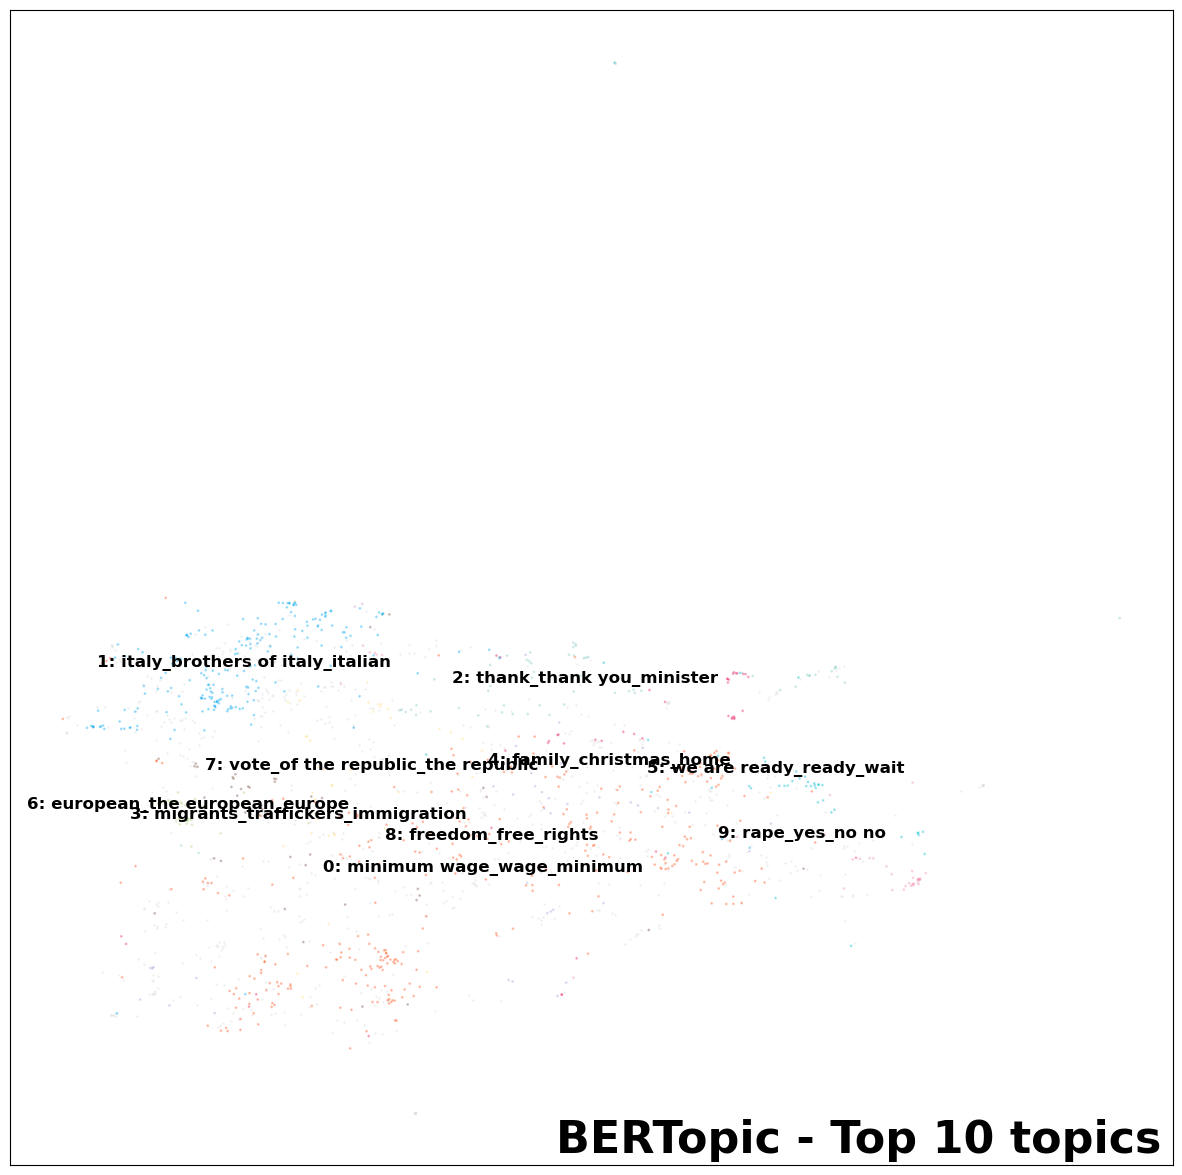

In [427]:
import matplotlib
import matplotlib.pyplot as plt

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)
The stop word vec taht does nto work.
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
topic_model.get_topic_info().head(50)